# Data Visualization

In this notebook, we demonstrate two simple examples of data visualization with [`matplotlib`](https://matplotlib.org) and [`seaborn`](https://seaborn.pydata.org). The data is obtained by querying a PostgreSQL database and performing most of the computation on the database side.

Copyright Marcel Maltry & Jens Dittrich, [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

# Setup

Again, we use the IMDb data provided by https://relational.fit.cvut.cz/dataset/IMDb. This time, we use the full dataset, so we start by importing it from .csv files into our local PostgreSQL database.

In [1]:
import psycopg

data_path = 'data/IMDb_full'

dsn = 'dbname=postgres user=postgres host=/var/run/postgresql/'  # host may be /tmp/ on other systems

**Note**: The following cell imports data from multiple .csv files into PostgreSQL. You only need to execute it once but it might take some time.

In [2]:
%%time

# Data source: https://relational.fit.cvut.cz/dataset/IMDb
# Information courtesy of IMDb (http://www.imdb.com). Used with permission.
#
# Notice: The data can only be used for personal and non-commercial use and must not
# be altered/republished/resold/repurposed to create any kind of online/offline
# database of movie information (except for individual personal use).

with psycopg.connect(dsn) as conn:
    conn.autocommit = True
    
    with conn.cursor() as cur:
        
        # Insert actors.csv
        with open(data_path + '/actors.csv', 'r') as file:
            cur.execute("DROP TABLE IF EXISTS actors CASCADE;")
            cur.execute("""
                CREATE TABLE actors
                (
                    id int PRIMARY KEY,
                    first_name varchar,
                    last_name varchar,
                    gender char
                );
                """
            )
            with cur.copy("""COPY actors(id, first_name, last_name, gender)
                             FROM stdin (FORMAT csv, DELIMITER '\t', NULL 'NULL', HEADER true);""") as copy:
                copy.write(file.read())

        # Insert movies.csv
        with open(data_path + '/movies.csv', 'r') as file:
            cur.execute("DROP TABLE IF EXISTS movies CASCADE;")
            cur.execute("""
                CREATE TABLE movies
                (
                    id int PRIMARY KEY,
                    name varchar,
                    year int,
                    rank float
                );
                """
            )
            with cur.copy("""COPY movies(id, name, year, rank)
                             FROM stdin (FORMAT csv, DELIMITER '\t', NULL 'NULL', HEADER true);""") as copy:
                copy.write(file.read())
            
        # Insert roles.csv
        with open(data_path + '/roles.csv', 'r') as file:
            cur.execute("DROP TABLE IF EXISTS roles;")
            cur.execute("""
                CREATE TABLE roles
                (
                    actor_id int REFERENCES actors(id),
                    movie_id int REFERENCES movies(id),
                    role varchar
                );
                """
            )
            with cur.copy("""COPY roles(actor_id, movie_id, role)
                             FROM stdin (FORMAT csv, DELIMITER '\t', NULL 'NULL', HEADER true);""") as copy:
                copy.write(file.read())
            
        # Insert movies_genres.csv
        with open(data_path + '/movies_genres.csv', 'r') as file:
            cur.execute("DROP TABLE IF EXISTS movies_genres;")
            cur.execute("""
                CREATE TABLE movies_genres
                (
                    movie_id int REFERENCES movies(id),
                    genre varchar
                );
                """
            )
            with cur.copy("""COPY movies_genres(movie_id, genre)
                             FROM stdin (FORMAT csv, DELIMITER '\t', NULL 'NULL', HEADER true);""") as copy:
                copy.write(file.read())
            
        # Insert fav_actors.csv
        with open(data_path + '/fav_actors.csv', 'r') as file:
            cur.execute("DROP TABLE IF EXISTS fav_actors;")
            cur.execute("""
                CREATE TABLE fav_actors
                (
                    actor_id int REFERENCES actors(id)
                );
                """
            )
            with cur.copy("""COPY fav_actors(actor_id)
                             FROM stdin (FORMAT csv, DELIMITER '\t', NULL 'NULL', HEADER true);""") as copy:
                copy.write(file.read())

CPU times: user 33.3 s, sys: 556 ms, total: 33.9 s
Wall time: 2min 24s


# Barplot

We first want to visualize the amount of movies produced per year since 1960. We can simply query this information by performing a `GROUP BY` on year and counting the members per group as follows:
```SQL
SELECT year, COUNT(*)
FROM
    movies m
WHERE year >= 1960
GROUP BY year
ORDER BY year
```
From the query result, we extract the years and counts into two separate lists.

In [4]:
with psycopg.connect(dsn) as conn:
    
    with conn.cursor() as cur:
        
        # Query number of movies by year
        movies_query = """
        SELECT year, COUNT(*)
        FROM
            movies m
        WHERE year >= 1960
        GROUP BY year
        ORDER BY year
        """
        cur.execute(movies_query)
        movies_result = cur.fetchall()
        
        years = [tup[0] for tup in movies_result]
        counts = [tup[1] for tup in movies_result]

With `matplotlib`, we can visualize the query result as a so called bar plot. This type of plot shows one bar for each year. On the x-axis, we have all the years from 1960 to 2008 and on the y-axis it shows the amount of movies produced in this year.

To achieve better control over the size of the plot, we define a subplot and then plot the bar plot on the axis returned by `plt.subplot()`. `bar()` takes as argument `x`, the number of bars on the x-axis, and `y` the values for each of the bars. We also specify the labels for the ticks on the x-axis and rotate them for better readability.

Note that the data seems to be from around 2003 which is why there seem to be less movies in the following years.

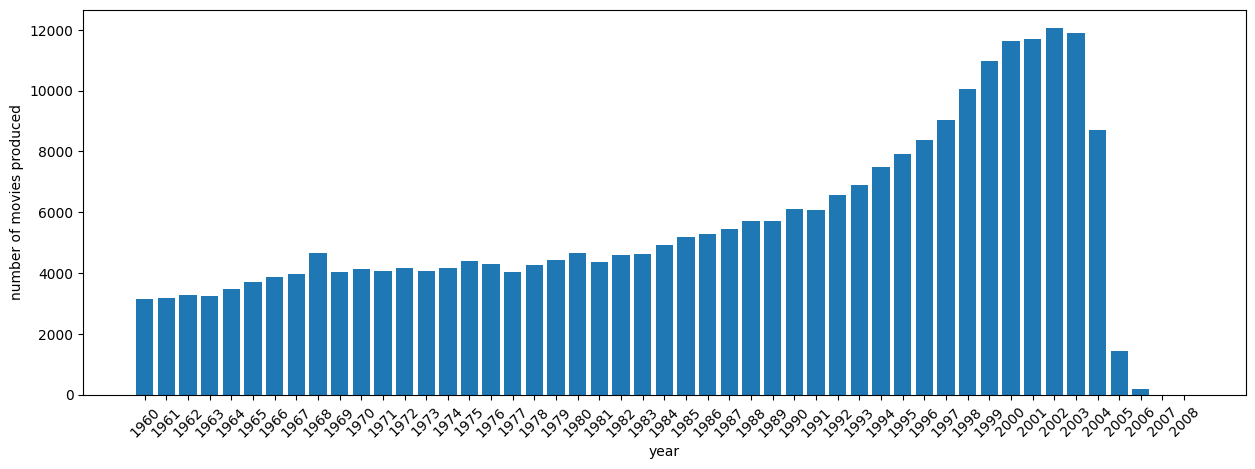

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define subplots and size
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Plot barplot
x = range(len(years))
y = counts
ax.bar(x, y, tick_label=years)

# Adjustments
ax.set_xlabel('year')
ax.set_ylabel('number of movies produced')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Heatmap

Next, we are interested in the genres of movies our favorite actors played in. For each of our favorite actors and each movie genre, we want to count the amount of movies of that genre the actor played in. We can achieve this by finding all the movies our favorite actors played in and then by grouping on both the actor and the genres as follows:
```SQL
SELECT
    concat(a.first_name,' ',a.last_name) AS name,
    mg.genre as genre,
    COUNT(*) AS cnt
FROM
    movies m,
    movies_genres mg,
    roles r,
    actors a,
    fav_actors fa
WHERE
    a.id = r.actor_id AND
    r.movie_id = m.id AND
    m.id = mg.movie_id AND
    fa.actor_id = a.id
GROUP BY a.id, mg.genre
ORDER BY name, genre;
```
Note that we insert all resulting tuples into a dictionary mapping a tuple of actor and genre to the number of movies of that genre the actor played a role in. We also query and extract the names of the actors and all the genres.

In [6]:
with psycopg.connect(dsn) as conn:
    
    with conn.cursor() as cur:

        # Query number of movies by favorite actor and genre
        group_query = """
        SELECT
            concat(a.first_name,' ',a.last_name) AS name,
            mg.genre as genre,
            COUNT(*) AS cnt
        FROM
            movies m,
            movies_genres mg,
            roles r,
            actors a,
            fav_actors fa
        WHERE
            a.id = r.actor_id AND
            r.movie_id = m.id AND
            m.id = mg.movie_id AND
            fa.actor_id = a.id
        GROUP BY a.id, mg.genre
        ORDER BY name, genre;
        """
        cur.execute(group_query)
        group_result = cur.fetchall()
        # Insert result into dictionary
        cnt_dict = dict()
        for tup in group_result:
            cnt_dict[(tup[0], tup[1])] = tup[2]

        # Query names of favorite actors
        actors_query = """
        SELECT
            concat(a.first_name,' ',a.last_name) AS name
        FROM
            actors a,
            fav_actors fa
        WHERE
            fa.actor_id = a.id
        ORDER BY name;
        """
        cur.execute(actors_query)
        actors = [tup[0] for tup in cur.fetchall()]

        # Query all genres
        genres_query = "SELECT DISTINCT genre from movies_genres ORDER BY genre;"
        cur.execute(genres_query)
        genres = [tup[0] for tup in cur.fetchall()]

Having gathered all the data, we decided to visualize the result as a heat map. You can think of a heatmap as a color coded pivot table where lower numbers and higher numbers share similar colors, respectively.

Before being able to visualize the query results as a heatmap, we have to transform our query result into a pivot table. We start by initializing an pivot table with zero in each cell. We then enter all the numbers from the dictionary into the pivot table. Note that if a combination of actor and genre does not exist, we enter 0 into the pivot table.

In [7]:
import numpy as np

# Build heat map
pivottable = np.zeros(shape=(len(actors), len(genres)))

for i, actor in enumerate(actors):
    for j, genre in enumerate(genres):
        pivottable[i][j] = cnt_dict.get((actor, genre), 0)

We now visualize the pivot table as a heatmap using `seaborn`. The function `heatmap()` takes as arguments `data` in form of a two dimensional array (our pivot table) along with some parameters that let us specify some visual components such as the tick lablels and the scholor scheme. We again call `subplots()` to be able to set a size for the plot. This time, we define two subplots to be able to showcase different coloring schemes.

<Axes: >

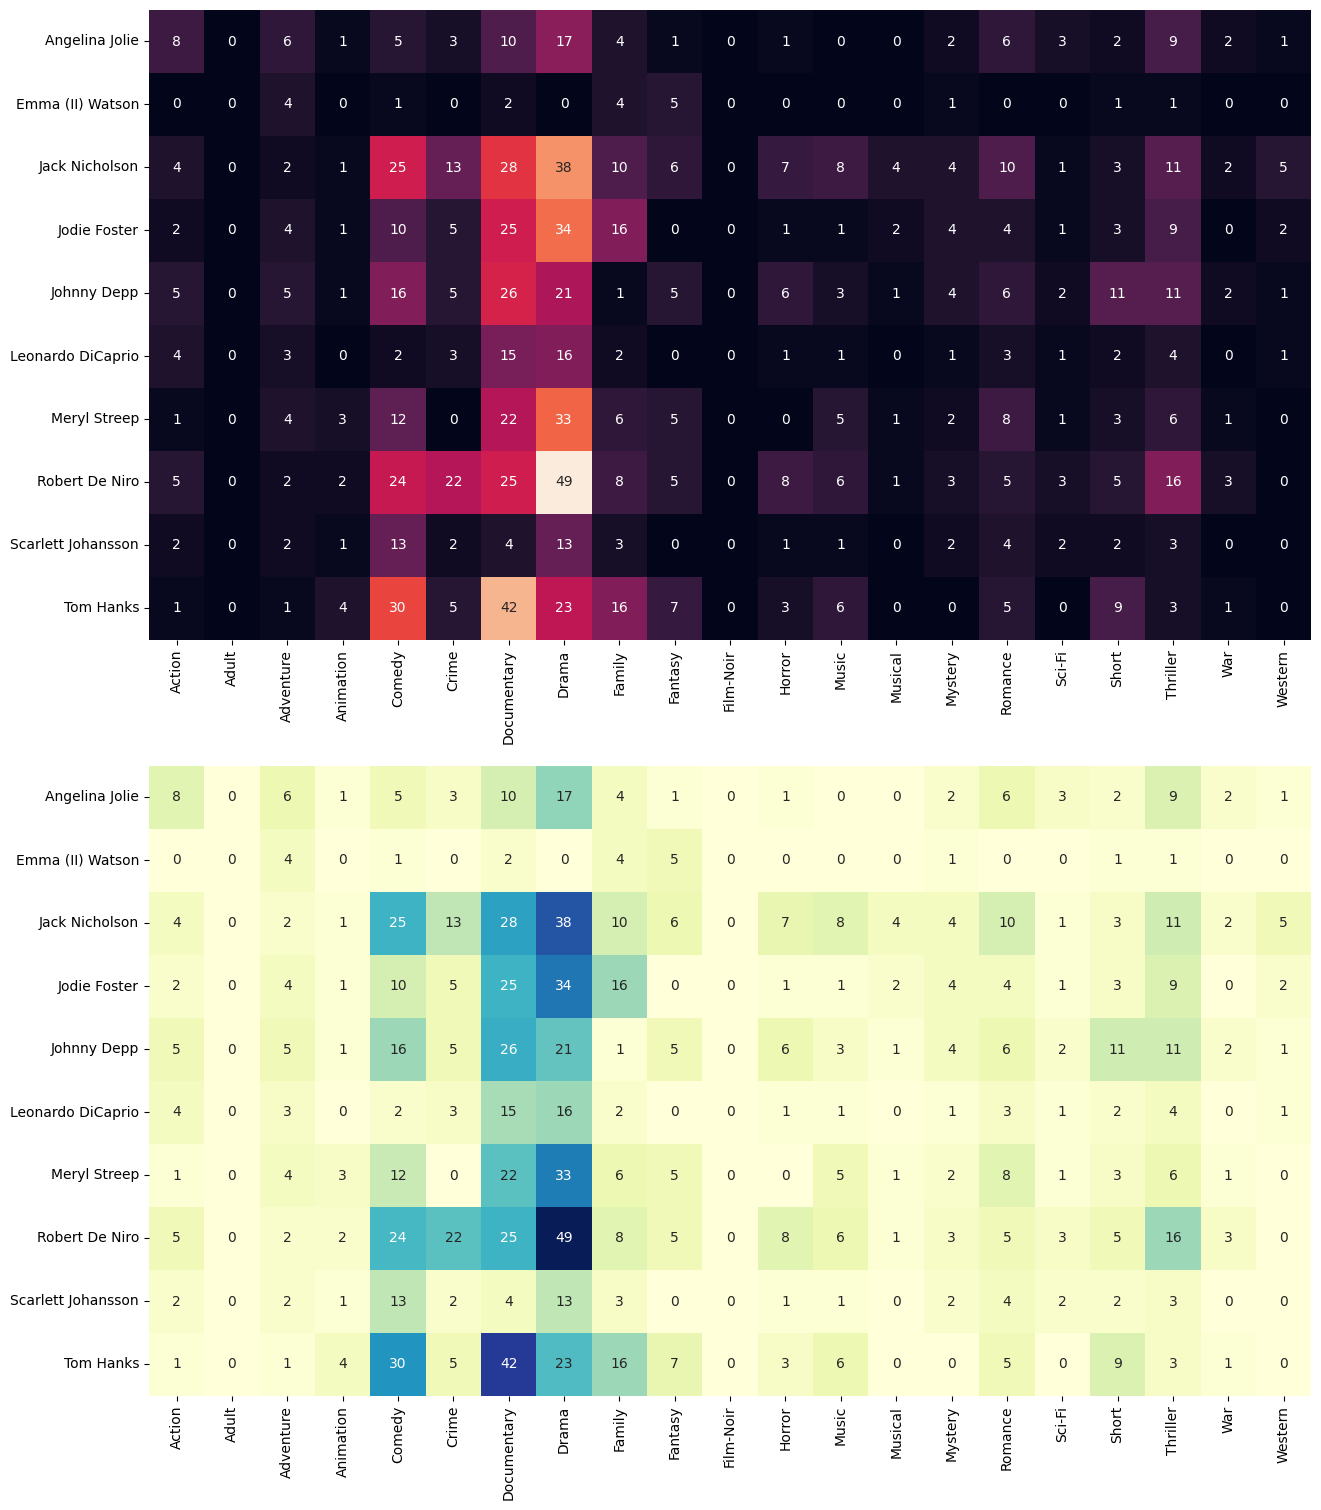

In [8]:
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(2, 1, figsize=(15,18))

# Plot heatmap
sns.heatmap(pivottable, ax=ax[0], annot=True,
            xticklabels=genres, yticklabels=actors, cbar=False)#, cmap="YlGnBu", cbar=False)

# Plot heatmap with other color scheme
sns.heatmap(pivottable, ax=ax[1], annot=True,
            xticklabels=genres, yticklabels=actors, cbar=False, cmap="YlGnBu")